Ilee+2018 https://ui.adsabs.harvard.edu/abs/2018ApJ...869L..24I/abstract

In [1]:
from astropy import units as u
distance = 3.37*u.kpc
vcen = 35 * u.km/u.s # from Patricio


In [2]:
cd /orange/adamginsburg/salt/sanhueza/G11

/orange/adamginsburg/salt/sanhueza/G11


In [3]:
ls

G11.92-0.61.config8.cont_avg.selfcal_0.5_hogbom.image.fits*
G11.92-0.61.config8.spw0.robust0.5.image_cb_smaller.fits
G11.92-0.61.config8.spw0.robust0.5.image_small.fits*
G11.92-0.61.config8.spw1.robust0.5.image_cb_smaller.fits
G11.92-0.61.config8.spw1.robust0.5.image_small.fits*
G11.92-0.61.config8.spw2.robust0.5.image_cb_smaller.fits
G11.92-0.61.config8.spw2.robust0.5.image_small.fits*
G11.92-0.61.config8.spw3.robust0.5.image_cb_smaller.fits
G11.92-0.61.config8.spw3.robust0.5.image_small.fits*
G11.92.zip*
NaCl_v_le_3_stackcube.fits
sourceAdisk.reg
sourceA.reg
sourceAsmaller.reg
sourceAsmall.reg
spectra/
vmap.fits
vmapm1.fits


In [4]:
%matplotlib inline
import pylab as pl
from spectral_cube import SpectralCube
from astropy import units as u
from astropy.visualization import quantity_support
quantity_support()

<astropy.visualization.units.quantity_support.<locals>.MplQuantityConverter at 0x2b4b09dfa640>

In [5]:
from astropy.table import Table
from astropy import table

In [6]:
import pprint

In [7]:
import scipy, scipy.ndimage

In [8]:
import numpy as np
import os
import glob
from astropy import constants, units as u, table, stats, coordinates, wcs, log, coordinates as coord
import radio_beam
import pyspeckit
import pylab as pl
pl.rcParams['figure.facecolor'] = 'w'
from astroquery.splatalogue.utils import minimize_table as mt
import sys
sys.path.append('/orange/adamginsburg/salt/Orion_ALMA_2016.1.00165.S/analysis')
import lines
import paths
from salt_tables import (salt_tables, salt_table_names, SO, SO2, HCl, sis_tables, AlCl, AlF, Al37Cl,
                         NaF, AlO, AlOH, NaCN, CaS, CaO)

In [9]:
import regions
from astropy import units as u, coordinates
reg = regions.Regions.read('sourceA.reg')
regsm = regions.Regions.read('sourceAsmall.reg')
regvsm = regions.Regions.read('sourceAsmaller.reg')
regvvsm = regions.Regions.read('sourceAdisk.reg')

#regvvsm = regions.Regions.read('.reg')

In [10]:
reg, regsm, regvsm

(<Regions([<CircleSkyRegion(center=<SkyCoord (FK5: equinox=J2000.000): (ra, dec) in deg
     (273.4921225, -18.9056375)>, radius=0.5 arcsec)>])>,
 <Regions([<CircleSkyRegion(center=<SkyCoord (FK5: equinox=J2000.000): (ra, dec) in deg
     (273.4921225, -18.9056375)>, radius=0.5 arcsec)>])>,
 <Regions([<CircleSkyRegion(center=<SkyCoord (FK5: equinox=J2000.000): (ra, dec) in deg
     (273.49213958, -18.90560833)>, radius=0.151 arcsec)>])>)

(2363.0, 2504.0, 2360.0, 2501.0)

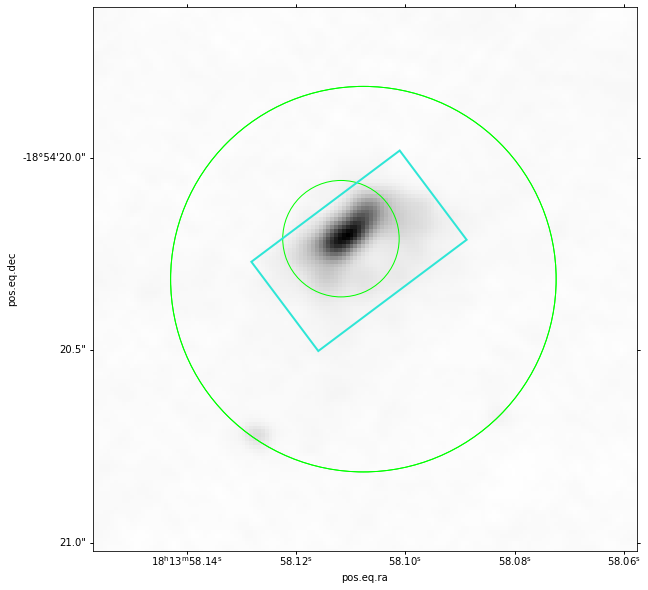

In [11]:
cont = SpectralCube.read('G11.92-0.61.config8.cont_avg.selfcal_0.5_hogbom.image.fits')
pl.figure(figsize=(10,10))
ax = pl.subplot(projection=cont[0].wcs)
ax.imshow(cont[0].value, cmap='gray_r')
reg[0].to_pixel(cont[0].wcs).plot(ax=ax)
regsm[0].to_pixel(cont[0].wcs).plot(ax=ax)
regvsm[0].to_pixel(cont[0].wcs).plot(ax=ax)
regvvsm[0].to_pixel(cont[0].wcs).plot(ax=ax)

pp = reg[0].to_pixel(cont.wcs.celestial)
bb = pp.bounding_box
ax.axis([bb.ixmin-20, bb.ixmax+20, bb.iymin-20, bb.iymax+20])

# NaCl Stackl

In [12]:
from spectral_cube.analysis_utilities import stack_cube

In [13]:
nacltables = salt_tables[3:5]

In [14]:
import spectral_cube.analysis_utilities
import imp
imp.reload(spectral_cube.analysis_utilities)
from spectral_cube.analysis_utilities import stack_cube

In [15]:
flist = sorted(glob.glob('G11.92-0.61.config8.spw[0-3].robust0.5.image_small.fits'))

In [16]:
for fn in flist:
    outfile = fn.replace("_small","_cb_smaller")
    if not os.path.exists(outfile) or (os.path.exists(outfile) and SpectralCube.read(outfile).unit != u.K):
        # for unknown reason, use_dask=True results in a problem
        cube = SpectralCube.read(fn, use_dask=False).subcube_from_regions(reg)
        cube.allow_huge_operations=True
        cb = cube.beams.common_beam(max_iter=20, max_epsilon=0.01)
        scube = cube.convolve_to(cb)
        scube.to(u.K).write(outfile, overwrite=True)

In [17]:
cbflist = sorted((glob.glob('G11.92-0.61.config8.spw[0-3].robust0.5.image_cb_smaller.fits')))
cubes = [SpectralCube.read(fn, use_dask=True).subcube_from_regions(reg) for fn in cbflist]
cubes

[DaskSpectralCube with shape=(1931, 100, 100) and unit=K and chunk size (1677, 100, 100):
  n_x:    100  type_x: RA---SIN  unit_x: deg    range:   273.491969 deg:  273.492260 deg
  n_y:    100  type_y: DEC--SIN  unit_y: deg    range:   -18.905781 deg:  -18.905506 deg
  n_s:   1931  type_s: FREQ      unit_s: Hz     range: 233562629130.300 Hz:235447493499.820 Hz,
 DaskSpectralCube with shape=(1930, 100, 100) and unit=K and chunk size (965, 100, 100):
  n_x:    100  type_x: RA---SIN  unit_x: deg    range:   273.491969 deg:  273.492260 deg
  n_y:    100  type_y: DEC--SIN  unit_y: deg    range:   -18.905781 deg:  -18.905506 deg
  n_s:   1930  type_s: FREQ      unit_s: Hz     range: 231062632435.800 Hz:232946520191.775 Hz,
 DaskSpectralCube with shape=(3860, 100, 100) and unit=K and chunk size (965, 100, 100):
  n_x:    100  type_x: RA---SIN  unit_x: deg    range:   273.491969 deg:  273.492260 deg
  n_y:    100  type_y: DEC--SIN  unit_y: deg    range:   -18.905781 deg:  -18.905506 deg
  n_s:

In [18]:
# only needed for VRSCs
if hasattr(cubes[0], 'beams'):
    beams = radio_beam.Beams(beams=[cube.beams.common_beam(max_iter=20, max_epsilon=0.01) for cube in cubes])
    cb=beams.common_beam()
else:
    beams = radio_beam.Beams(beams=[cube.beam for cube in cubes])
    cb=beams.common_beam()
jtok = cb.jtok(217*u.GHz)

In [19]:
cb

Beam: BMAJ=0.10291057080030432 arcsec BMIN=0.06970372051000572 arcsec BPA=-84.39086151123047 deg

In [20]:
(cb.major*distance).to(u.au, u.dimensionless_angles())

<Quantity 346.8086236 AU>

In [21]:
(cb.minor*distance).to(u.au, u.dimensionless_angles())

<Quantity 234.90153812 AU>

In [22]:
linelist = np.concatenate([data['Freq'][(data['vu'] <= 3) &
                                          np.any([((data['Freq'].quantity > cube.spectral_extrema[0]) &
                                                   (data['Freq'].quantity < cube.spectral_extrema[1]))
                                                 for cube in cubes],
                                                 axis=0)].quantity
                             for data in nacltables])
linenames = np.concatenate( [data['Species'][(data['vu'] <= 3) &
                                          np.any([((data['Freq'].quantity > cube.spectral_extrema[0]) &
                                                   (data['Freq'].quantity < cube.spectral_extrema[1]))
                                                 for cube in cubes],
                                                 axis=0)]
                             for data in nacltables] )
(linelist, linenames)

(<Quantity [217.980231, 219.614936, 232.509977, 234.251912] GHz>,
 array(['23Na-35Clv=2-2 J=17-16', '23Na-35Clv=1-1 J=17-16',
        '23Na-35Clv=1-1 J=18-17', '23Na-35Clv=0-0 J=18-17'], dtype='<U24'))

In [23]:
from astropy import log
log.setLevel('INFO')

In [24]:
#log.setLevel('DEBUG')
vcen = 35 * u.km/u.s # from Patricio
stack, cutouts = stack_cube(cubes,
                   linelist=linelist,
                   vmin=vcen-30*u.km/u.s,
                   vmax=vcen+30*u.km/u.s,
                   average=np.nanmean,
                   convolve_beam=cb,
                   return_cutouts=True)
#log.setLevel('INFO')
stack.to(u.K).write('NaCl_v_le_3_stackcube.fits', overwrite=True)

Mean of empty slice


In [25]:
stackc = SpectralCube.read('NaCl_v_le_3_stackcube.fits', use_dask=True).to(u.K)
stackc

DaskSpectralCube with shape=(91, 100, 100) and unit=K and chunk size (91, 100, 100):
 n_x:    100  type_x: RA---SIN  unit_x: deg    range:   273.491969 deg:  273.492260 deg
 n_y:    100  type_y: DEC--SIN  unit_y: deg    range:   -18.905781 deg:  -18.905506 deg
 n_s:     91  type_s: VRAD      unit_s: km / s  range:        4.824 km / s:      65.266 km / s

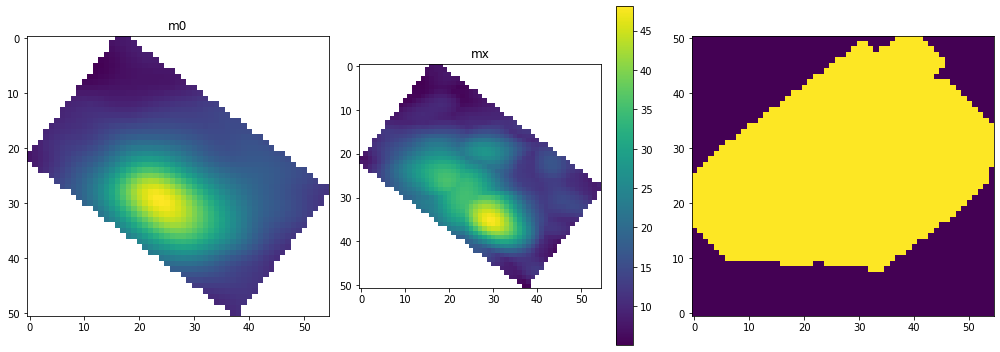

<Figure size 432x288 with 0 Axes>

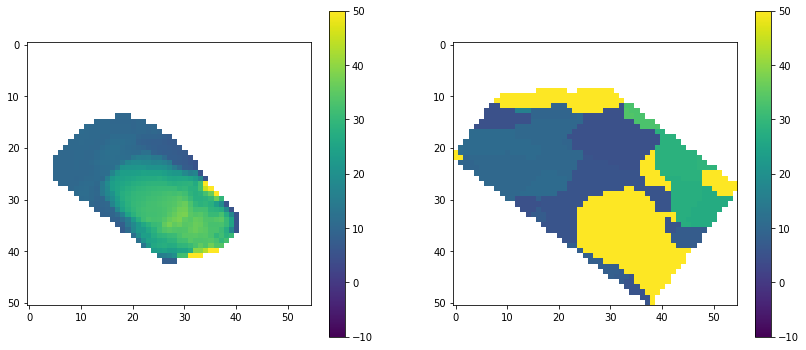

In [26]:
stackc = stackc.subcube_from_regions(regvvsm)
pl.figure(figsize=(14,5))
pl.subplot(1,3,1)
m0 = stackc.moment0()
m0.quicklook()
pl.title("m0")

pl.subplot(1,3,2)
mx = stackc.max(axis=0)
mx.quicklook()
pl.title("mx")
pl.colorbar()
pl.subplot(1,3,3)
msk = mx > 10*u.K
msk = scipy.ndimage.binary_erosion(msk, iterations=1)
msk = scipy.ndimage.binary_dilation(msk, iterations=5)
pl.imshow(msk, interpolation='none', origin='lower')
pl.tight_layout()
pl.figure()

from dask_image.ndmorph import binary_dilation, binary_erosion
m3d = (stackc > 15*u.K).include()
m3d = binary_erosion(m3d, iterations=1)
m3d = binary_dilation(m3d, iterations=2)
m3d = m3d.compute()


m1 = stackc.with_mask(msk).with_mask(m3d).moment1()
pl.figure(figsize=(14,6))
ax1 = pl.subplot(1,2,1)
im = ax1.imshow(m1.value, vmin=-10, vmax=50)
pl.colorbar(mappable=im)
mxv = stackc.with_mask(msk).argmax_world(axis=0)
pl.subplot(1,2,2)
pl.imshow(mxv.value, vmin=-10, vmax=50)
pl.colorbar()


#vmap = mxv.hdu
vmap = m1.hdu

In [27]:
from astroquery.splatalogue import Splatalogue
Splatalogue.query_lines(232.3929*u.GHz * (1+30/3e5), 232.3929*u.GHz * (1+40/3e5), energy_max=1000, energy_type='eu_k', chemical_name='oxide')
Splatalogue.query_lines(232.3929*u.GHz * (1+30/3e5), 232.3929*u.GHz * (1+40/3e5), energy_max=1000, energy_type='eu_k', chemical_name='Methanol')
#232.4195*(1-35/3e5)

Species,Chemical Name,"Freq-GHz(rest frame,redshifted)","Freq Err(rest frame,redshifted)","Meas Freq-GHz(rest frame,redshifted)","Meas Freq Err(rest frame,redshifted)",Resolved QNs,CDMS/JPL Intensity,S<sub>ij</sub>&#956;<sup>2</sup> (D<sup>2</sup>),S<sub>ij</sub>,Log<sub>10</sub> (A<sub>ij</sub>),Lovas/AST Intensity,E_L (cm^-1),E_L (K),E_U (cm^-1),E_U (K),Upper State Degeneracy,Linelist
str11,str8,float64,float64,float64,float64,str21,float64,float64,float64,float64,int64,float64,float64,float64,float64,float64,str5
CH3OHvt=0-2,Methanol,232.418521,1.2e-05,--,--,"10(2,8)-9(3,7)A,vt=0",-4.2131,10.73599,0.0,-4.72869,--,107.2078,154.24722,114.96045,165.40149,84.0,CDMS
CH3OHvt=0-2,Methanol,232.418521,1.2e-05,--,--,10(2)+-9(3)+vt=0,-4.2242,2.6774,0.0,-4.72976,--,107.208,154.24751,114.96065,165.40178,21.0,JPL
CH3OH(OSU),Methanol,--,--,232.41856191,2.6e-08,--,-0.26453,2.60276,0.0,0.0,--,109.395,157.39603,117.14765,168.55043,0.0,OSU
CH3OHvt=0-2,Methanol,232.418571,1.6e-05,232.41859,5e-05,"10(2,8)-9(3,7)++",-4.05184,2.6864,0.0,-4.72829,--,107.208,154.24751,114.96065,165.40178,21.0,SLAIM
CH3OHvt=0-2,Methanol,232.4195,0.000484,--,--,"7(6,1)-7(7,0),vt=1",0.0,0.57214,0.0,-5.25383,--,448.967,645.96007,456.71968,657.11439,15.0,CDMS
CH3OHvt=0-2,Methanol,232.4195,0.000484,--,--,"7(6,1)-7(7,0)vt=1",0.0,0.5722,0.0,-5.25378,--,448.967,645.96007,456.71968,657.11439,15.0,SLAIM
CH3OHvt=0-2,Methanol,232.422803,4.6e-05,--,--,"7(-6,1)-7(-7,0)E,vt=1",-5.5981,2.27851,0.0,-5.25573,--,448.9666,645.95907,456.71939,657.11355,60.0,CDMS
CH3OHvt=0-2,Methanol,232.422803,4.6e-05,--,--,7(6)-7(7)E1vt=1,-5.6081,0.56967,0.0,-5.2557,--,448.967,645.95965,456.71979,657.11412,15.0,JPL
CH3OH(OSU),Methanol,--,--,232.42300192,7.35e-07,--,-1.69352,0.36615,0.0,0.0,--,386.529,556.13263,394.2818,567.28725,0.0,OSU


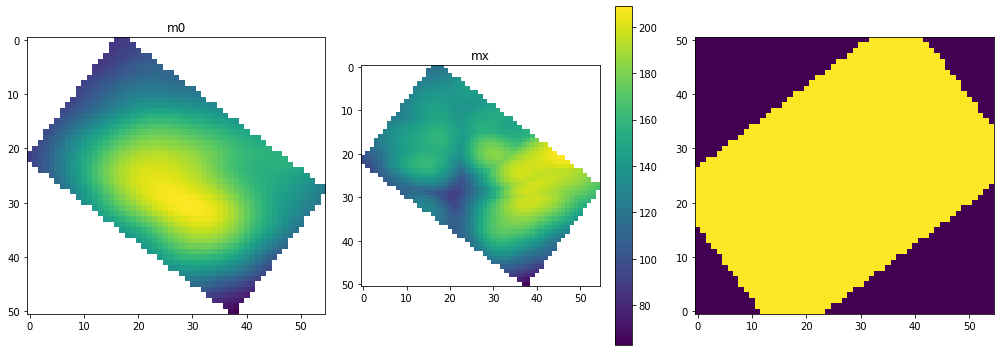

<Figure size 432x288 with 0 Axes>

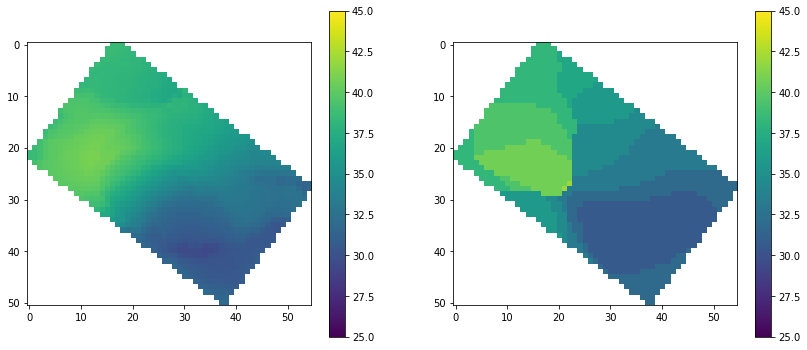

In [28]:
# try creating a vmap based on another line
restval = 232.3929*u.GHz 
restval = 232.4195*u.GHz*(1-35*u.km/u.s/constants.c) # CH3OH 7(6,1)-7(7,0)vt=1	
restval = 232.418521*u.GHz # CH3OH 10(2,8)-9(3,7)A,vt=0	
#restval = 219.94944000*u.GHz # SO 65-54
cube = [c for c in cubes if (c.spectral_extrema[0] < restval) & (c.spectral_extrema[1] > restval)][0]

scube = cube.subcube_from_regions(regvvsm).with_spectral_unit(u.km/u.s,
                                                             velocity_convention='radio',
                                                             rest_value=restval).spectral_slab(vcen-20*u.km/u.s, vcen+20*u.km/u.s)
pl.figure(figsize=(14,5))
pl.subplot(1,3,1)
m0 = scube.moment0()
m0.quicklook()
pl.title("m0")

pl.subplot(1,3,2)
mx = scube.max(axis=0)
mx.quicklook()
pl.title("mx")
pl.colorbar()
pl.subplot(1,3,3)
msk = mx > 25*u.K
msk = scipy.ndimage.binary_erosion(msk, iterations=1)
msk = scipy.ndimage.binary_dilation(msk, iterations=5)
pl.imshow(msk, interpolation='none', origin='lower')
pl.tight_layout()
pl.figure()


from dask_image.ndmorph import binary_dilation, binary_erosion
m3d = (scube > 15*u.K).include()
m3d = binary_erosion(m3d, iterations=1)
m3d = binary_dilation(m3d, iterations=2)
m3d = m3d.compute()



m1 = scube.with_mask(msk).with_mask(m3d).moment1()
pl.figure(figsize=(14,6))
ax1 = pl.subplot(1,2,1)
im = ax1.imshow(m1.value, vmin=vcen.value-10, vmax=vcen.value+10)
pl.colorbar(mappable=im)
mxv = scube.with_mask(msk).argmax_world(axis=0)
pl.subplot(1,2,2)
pl.imshow(mxv.value, vmin=vcen.value-10, vmax=vcen.value+10)
pl.colorbar()

vmapm1 = m1.hdu
vmap = mxv.hdu
# the rest value selected above was just the line center; we need to assume it's really 35 km/s off
vmap.data = vmap.data

In [29]:
import sys
sys.path.append('/orange/adamginsburg/salt/code/')
from overplot_saltlines import overplot_saltlines

In [30]:
spectra = []
for ii,cube in enumerate(cubes):
    cube.allow_huge_operations=True
    sp = cube.subcube_from_regions(regsm).mean(axis=(1,2))
    pysp = pyspeckit.Spectrum(data=sp, xarr=sp.spectral_axis, header=sp.header)
    spectra.append(pysp)
    pysp.specname = f'G11.92 average spw{ii+1}'

In [31]:
mkdir -p spectra/figures

G11.92_average_spw1
G11.92_average_spw2


G11.92_average_spw3
G11.92_average_spw4


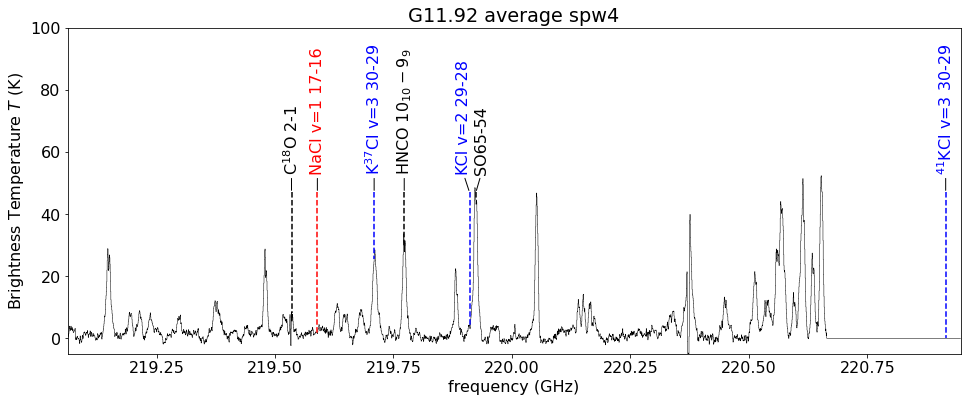

In [32]:
overplot_saltlines(spectra, vcen=vcen, savepath='spectra/figures', ymin=-5, ymax=100, yfrac=0.55)

In [33]:
ls spectra/figures

color_labels_G11.92-0.61_spw0_moment1stack.png
color_labels_G11.92-0.61_spw0_stack.png
color_labels_G11.92-0.61_spw1_moment1stack.png
color_labels_G11.92-0.61_spw1_stack.png
color_labels_G11.92-0.61_spw2_moment1stack.png
color_labels_G11.92-0.61_spw2_stack.png
color_labels_G11.92-0.61_spw3_moment1stack.png
color_labels_G11.92-0.61_spw3_stack.png
color_labels_G11.92_average_spw1.png
color_labels_G11.92_average_spw2.png
color_labels_G11.92_average_spw3.png
color_labels_G11.92_average_spw4.png
color_labels_spw1.png
color_labels_spw2.png
color_labels_spw3.png
color_labels_spw4.png
G11_61_stack.png
G11.92-0.61.config8.spw0.robust0.5.image_cb_smaller_moment1stack.pdf
G11.92-0.61.config8.spw0.robust0.5.image_cb_smaller_moment1stack.png
G11.92-0.61.config8.spw0.robust0.5.image_cb_smaller_stack.pdf
G11.92-0.61.config8.spw0.robust0.5.image_cb_smaller_stack.png
G11.92-0.61.config8.spw1.robust0.5.image_cb_smaller_moment1stack.pdf
G11.92-0.61.config8.spw1.robust0.5.image_cb_smaller_moment1stack.png

In [34]:
from IPython.display import Image,display

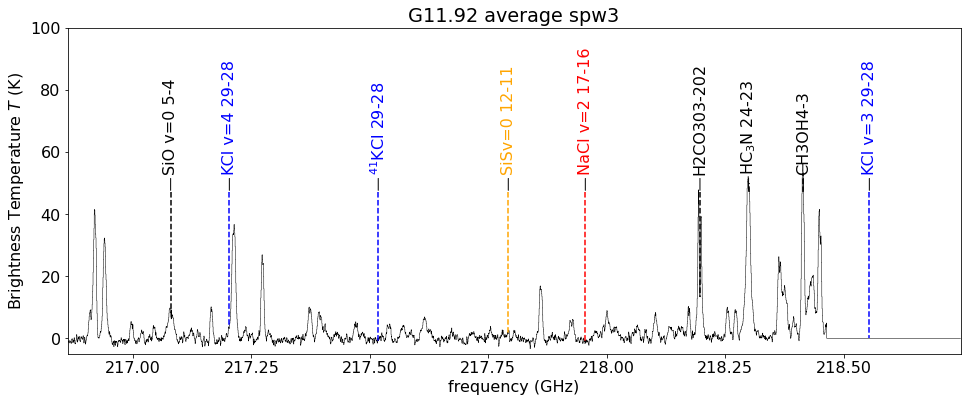

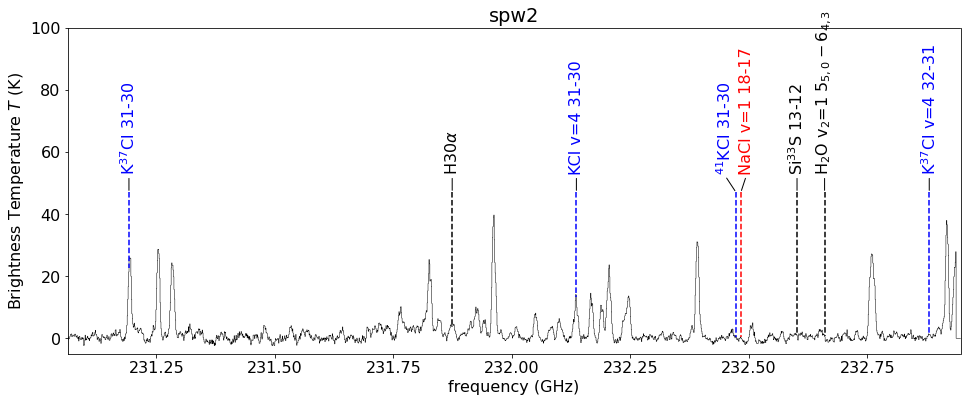

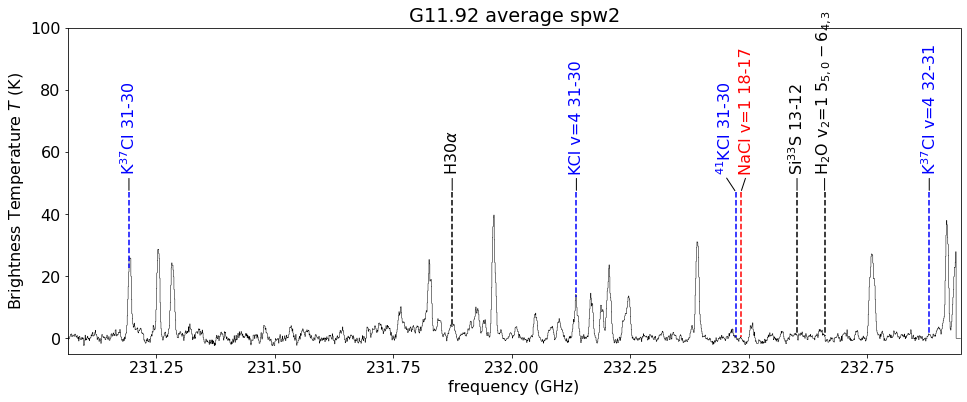

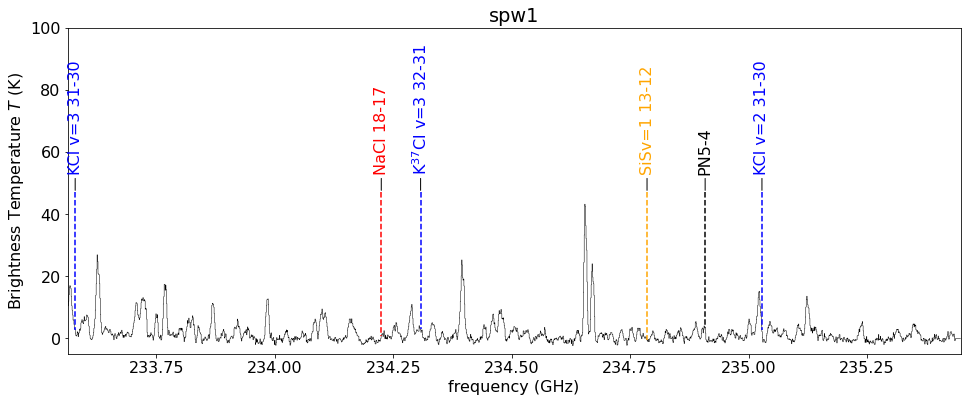

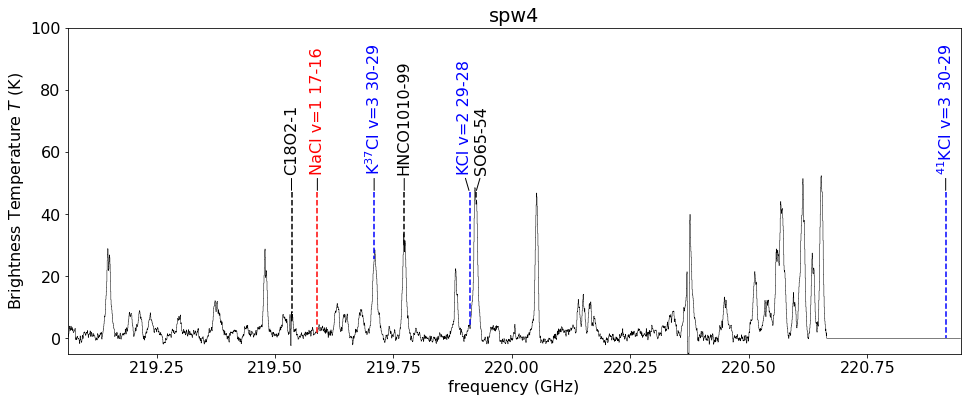

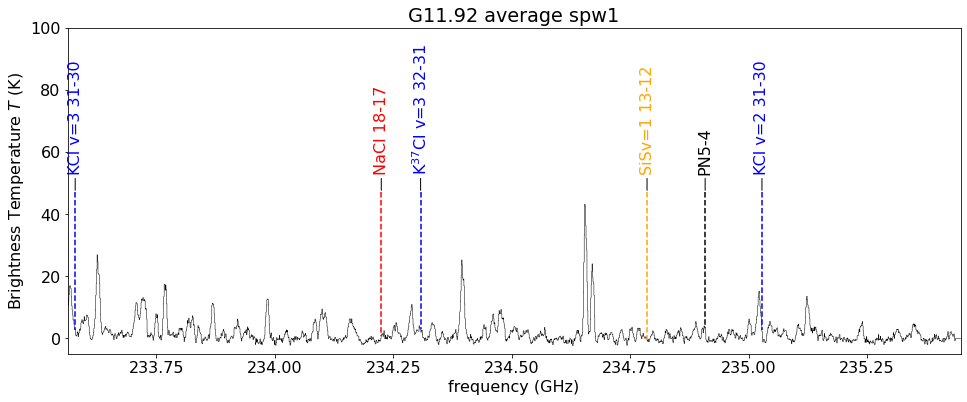

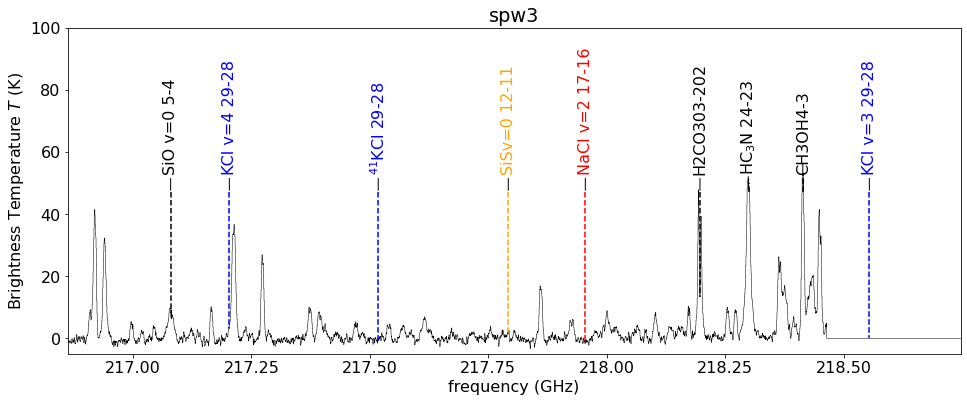

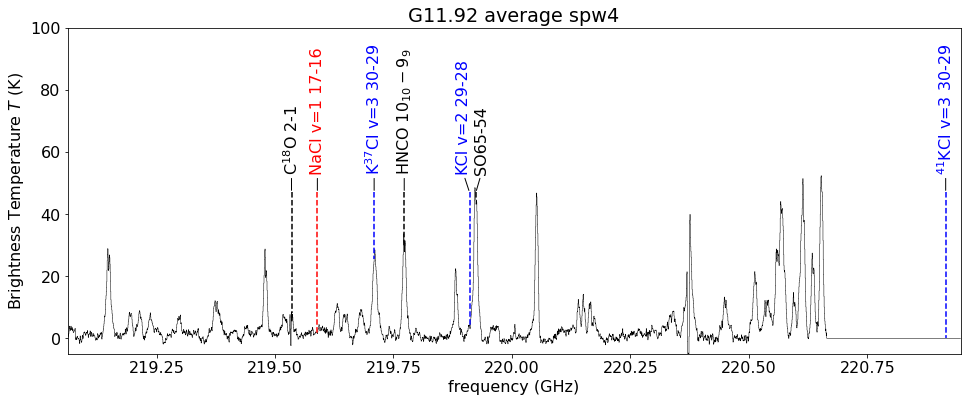

In [35]:
for fn in glob.glob('spectra/figures/color*spw[0-4].png'):
    display(Image(fn))

DaskSpectralCube with shape=(1931, 100, 100) and unit=K and chunk size (1677, 100, 100):
 n_x:    100  type_x: RA---SIN  unit_x: deg    range:   273.491969 deg:  273.492260 deg
 n_y:    100  type_y: DEC--SIN  unit_y: deg    range:   -18.905781 deg:  -18.905506 deg
 n_s:   1931  type_s: FREQ      unit_s: Hz     range: 233562629130.300 Hz:235447493499.820 Hz
Mean spectrum
Stacking
DaskSpectralCube with shape=(1930, 100, 100) and unit=K and chunk size (965, 100, 100):
 n_x:    100  type_x: RA---SIN  unit_x: deg    range:   273.491969 deg:  273.492260 deg
 n_y:    100  type_y: DEC--SIN  unit_y: deg    range:   -18.905781 deg:  -18.905506 deg
 n_s:   1930  type_s: FREQ      unit_s: Hz     range: 231062632435.800 Hz:232946520191.775 Hz
Mean spectrum
Stacking


DaskSpectralCube with shape=(3860, 100, 100) and unit=K and chunk size (965, 100, 100):
 n_x:    100  type_x: RA---SIN  unit_x: deg    range:   273.491969 deg:  273.492260 deg
 n_y:    100  type_y: DEC--SIN  unit_y: deg    range:   -18.905781 deg:  -18.905506 deg
 n_s:   3860  type_s: FREQ      unit_s: Hz     range: 216862407057.700 Hz:218746783120.389 Hz
Mean spectrum
Stacking


DaskSpectralCube with shape=(3860, 100, 100) and unit=K and chunk size (965, 100, 100):
 n_x:    100  type_x: RA---SIN  unit_x: deg    range:   273.491969 deg:  273.492260 deg
 n_y:    100  type_y: DEC--SIN  unit_y: deg    range:   -18.905781 deg:  -18.905506 deg
 n_s:   3860  type_s: FREQ      unit_s: Hz     range: 219062404148.900 Hz:220946780211.589 Hz
Mean spectrum
Stacking


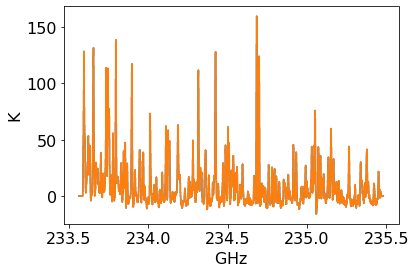

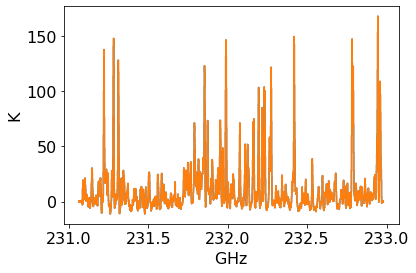

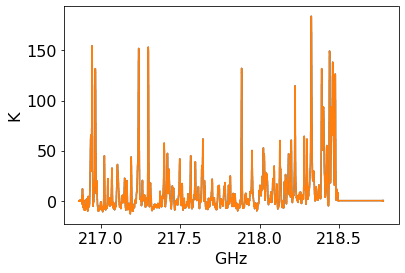

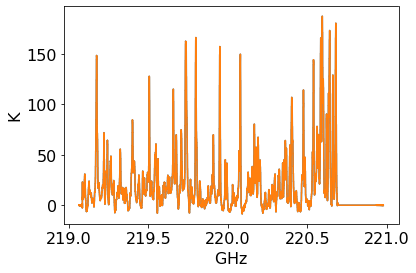

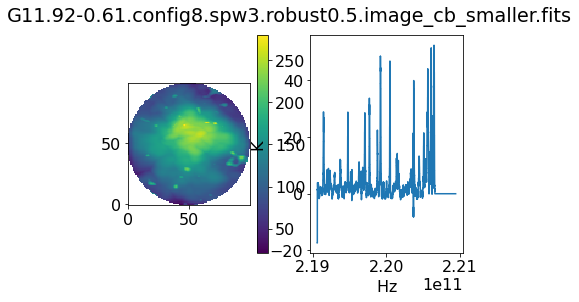

In [36]:
import glob
import spectral_cube.analysis_utilities
import reproject
from tqdm.notebook import tqdm
from astropy.io import fits

for fn in cbflist:
    basename = os.path.split(fn)[-1].split(".fits")[0]
    try:
        cube = SpectralCube.read(fn, use_dask=True)
    except Exception as ex:
        print(ex)
        continue
    print(cube)
    scube = cube.subcube_from_regions(regsm)
    mx = scube.max(axis=0)
    #msk = mx > 0.003*mx.unit
    print("Mean spectrum")
    sp = scube.mean(axis=(1,2))
    
    sp.write(f'spectra/{fn.split("/")[-1].replace(".fits","_meanspec.fits")}', overwrite=True)


    # reproject the velocity map into the cube's coordinate system
    vmap_proj,_ = reproject.reproject_interp(vmap,
                                             scube.wcs.celestial,
                                             shape_out=scube.shape[1:])
    fits.PrimaryHDU(data=vmap_proj, header=scube.wcs.celestial.to_header()).writeto('vmap.fits', overwrite=True)
    vmap_proj = u.Quantity(vmap_proj, u.km/u.s)
    # convert to km/s with arbitrary rest value so 0 km/s can be interpreted
    if scube.spectral_axis.unit.is_equivalent(u.Hz):
        scube = scube.with_spectral_unit(u.km/u.s, velocity_convention='radio', rest_value=scube.spectral_axis.mean())

    print("Stacking")
    # perform the stacking!
    stack = spectral_cube.analysis_utilities.stack_spectra(scube, vmap_proj,
                                                           v0=0.0*u.km/u.s,
                                                           #progressbar=tqdm,
                                                           #num_cores=8
                                                          )
    fstack = stack.with_spectral_unit(u.GHz)

    pl.suptitle(f"{fn}")
    fstack.write(f'spectra/{basename}_stack.fits', overwrite=True)

    pl.clf()
    fstack.quicklook(filename=f'spectra/figures/{basename}_stack.pdf')
    fstack.quicklook(filename=f'spectra/figures/{basename}_stack.png')
    
    
    fig = pl.figure()
    mappable = pl.subplot(1,2,1).imshow(mx.value, origin='lower', interpolation='none')
    pl.colorbar(mappable)
    pl.subplot(1,2,2)
    pl.suptitle(fn)
    sp.quicklook()

DaskSpectralCube with shape=(1931, 100, 100) and unit=K and chunk size (1677, 100, 100):
 n_x:    100  type_x: RA---SIN  unit_x: deg    range:   273.491969 deg:  273.492260 deg
 n_y:    100  type_y: DEC--SIN  unit_y: deg    range:   -18.905781 deg:  -18.905506 deg
 n_s:   1931  type_s: FREQ      unit_s: Hz     range: 233562629130.300 Hz:235447493499.820 Hz
Mean spectrum
Stacking
DaskSpectralCube with shape=(1930, 100, 100) and unit=K and chunk size (965, 100, 100):
 n_x:    100  type_x: RA---SIN  unit_x: deg    range:   273.491969 deg:  273.492260 deg
 n_y:    100  type_y: DEC--SIN  unit_y: deg    range:   -18.905781 deg:  -18.905506 deg
 n_s:   1930  type_s: FREQ      unit_s: Hz     range: 231062632435.800 Hz:232946520191.775 Hz
Mean spectrum
Stacking


DaskSpectralCube with shape=(3860, 100, 100) and unit=K and chunk size (965, 100, 100):
 n_x:    100  type_x: RA---SIN  unit_x: deg    range:   273.491969 deg:  273.492260 deg
 n_y:    100  type_y: DEC--SIN  unit_y: deg    range:   -18.905781 deg:  -18.905506 deg
 n_s:   3860  type_s: FREQ      unit_s: Hz     range: 216862407057.700 Hz:218746783120.389 Hz
Mean spectrum
Stacking


DaskSpectralCube with shape=(3860, 100, 100) and unit=K and chunk size (965, 100, 100):
 n_x:    100  type_x: RA---SIN  unit_x: deg    range:   273.491969 deg:  273.492260 deg
 n_y:    100  type_y: DEC--SIN  unit_y: deg    range:   -18.905781 deg:  -18.905506 deg
 n_s:   3860  type_s: FREQ      unit_s: Hz     range: 219062404148.900 Hz:220946780211.589 Hz
Mean spectrum
Stacking


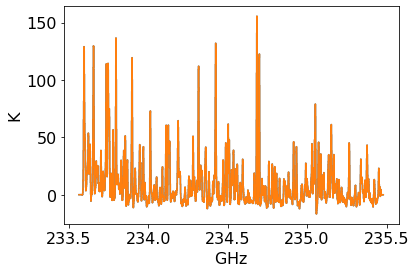

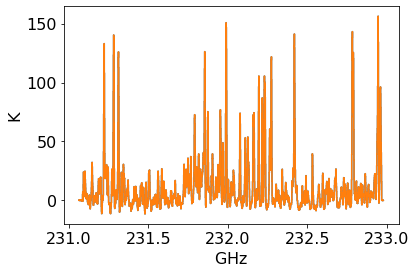

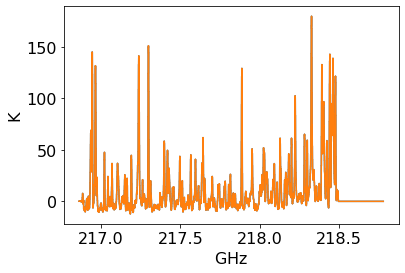

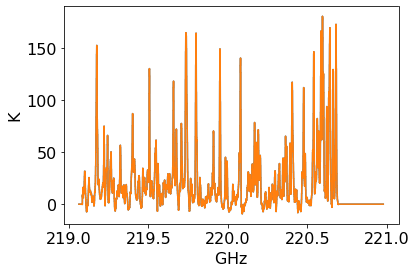

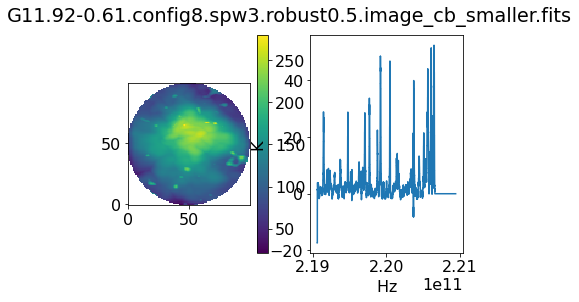

In [38]:
for fn in cbflist:
    basename = os.path.split(fn)[-1].split(".fits")[0]
    try:
        cube = SpectralCube.read(fn, use_dask=True)
    except Exception as ex:
        print(ex)
        continue
    print(cube)
    scube = cube.subcube_from_regions(regsm)
    mx = scube.max(axis=0)
    #msk = mx > 0.003*mx.unit
    print("Mean spectrum")
    sp = scube.mean(axis=(1,2))
    
    sp.write(f'spectra/{fn.split("/")[-1].replace(".fits","_meanspec.fits")}', overwrite=True)


    # reproject the velocity map into the cube's coordinate system
    vmap_proj,_ = reproject.reproject_interp(vmapm1,
                                             scube.wcs.celestial,
                                             shape_out=scube.shape[1:])
    fits.PrimaryHDU(data=vmap_proj, header=scube.wcs.celestial.to_header()).writeto('vmapm1.fits', overwrite=True)
    vmap_proj = u.Quantity(vmap_proj, u.km/u.s)
    # convert to km/s with arbitrary rest value so 0 km/s can be interpreted
    if scube.spectral_axis.unit.is_equivalent(u.Hz):
        scube = scube.with_spectral_unit(u.km/u.s, velocity_convention='radio', rest_value=scube.spectral_axis.mean())

    print("Stacking")
    # perform the stacking!
    stack = spectral_cube.analysis_utilities.stack_spectra(scube, vmap_proj,
                                                           v0=0.0*u.km/u.s,
                                                           #progressbar=tqdm,
                                                           #num_cores=8
                                                          )
    fstack = stack.with_spectral_unit(u.GHz)

    pl.suptitle(f"{fn}")
    fstack.write(f'spectra/{basename}_moment1stack.fits', overwrite=True)

    pl.clf()
    fstack.quicklook(filename=f'spectra/figures/{basename}_moment1stack.pdf')
    fstack.quicklook(filename=f'spectra/figures/{basename}_moment1stack.png')
    
    
    fig = pl.figure()
    mappable = pl.subplot(1,2,1).imshow(mx.value, origin='lower', interpolation='none')
    pl.colorbar(mappable)
    pl.subplot(1,2,2)
    pl.suptitle(fn)
    sp.quicklook()

In [39]:
ls spectra

figures/
G11.92-0.61.config8.spw0.robust0.5.image_cb_smaller_meanspec.fits
G11.92-0.61.config8.spw0.robust0.5.image_cb_smaller_moment1stack.fits
G11.92-0.61.config8.spw0.robust0.5.image_cb_smaller_stack.fits
G11.92-0.61.config8.spw1.robust0.5.image_cb_smaller_meanspec.fits
G11.92-0.61.config8.spw1.robust0.5.image_cb_smaller_moment1stack.fits
G11.92-0.61.config8.spw1.robust0.5.image_cb_smaller_stack.fits
G11.92-0.61.config8.spw2.robust0.5.image_cb_smaller_meanspec.fits
G11.92-0.61.config8.spw2.robust0.5.image_cb_smaller_moment1stack.fits
G11.92-0.61.config8.spw2.robust0.5.image_cb_smaller_stack.fits
G11.92-0.61.config8.spw3.robust0.5.image_cb_smaller_meanspec.fits
G11.92-0.61.config8.spw3.robust0.5.image_cb_smaller_moment1stack.fits
G11.92-0.61.config8.spw3.robust0.5.image_cb_smaller_stack.fits


In [40]:
stackspectra = []
for ii,fn in enumerate(glob.glob('spectra/*_stack.fits')):
    pysp = pyspeckit.Spectrum(fn)
    basename = os.path.basename(fn)
    spl = basename.split(".")
    pysp.specname = f'{".".join(spl[0:3])} {spl[4]} stack'
    print(pysp.specname)
    stackspectra.append(pysp)

G11.92-0.61 spw2 stack
G11.92-0.61 spw1 stack
G11.92-0.61 spw0 stack
G11.92-0.61 spw3 stack


G11.92-0.61_spw2_stack
G11.92-0.61_spw1_stack
G11.92-0.61_spw0_stack
G11.92-0.61_spw3_stack


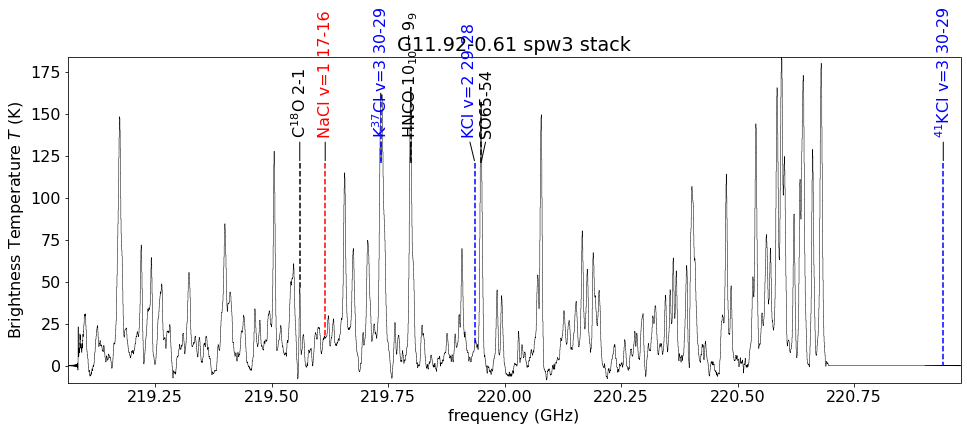

In [41]:
overplot_saltlines(stackspectra, vcen=0*u.km/u.s, savepath='spectra/figures')

In [42]:
momstackspectra = []
for ii,fn in enumerate(glob.glob('spectra/*_moment1stack.fits')):
    pysp = pyspeckit.Spectrum(fn)
    basename = os.path.basename(fn)
    spl = basename.split(".")
    pysp.specname = f'{".".join(spl[0:3])} {spl[4]} moment stack'
    print(pysp.specname)
    momstackspectra.append(pysp)

G11.92-0.61 spw3 moment stack
G11.92-0.61 spw0 moment stack
G11.92-0.61 spw2 moment stack
G11.92-0.61 spw1 moment stack


G11.92-0.61_spw3_moment_stack
G11.92-0.61_spw0_moment_stack
G11.92-0.61_spw2_moment_stack
G11.92-0.61_spw1_moment_stack


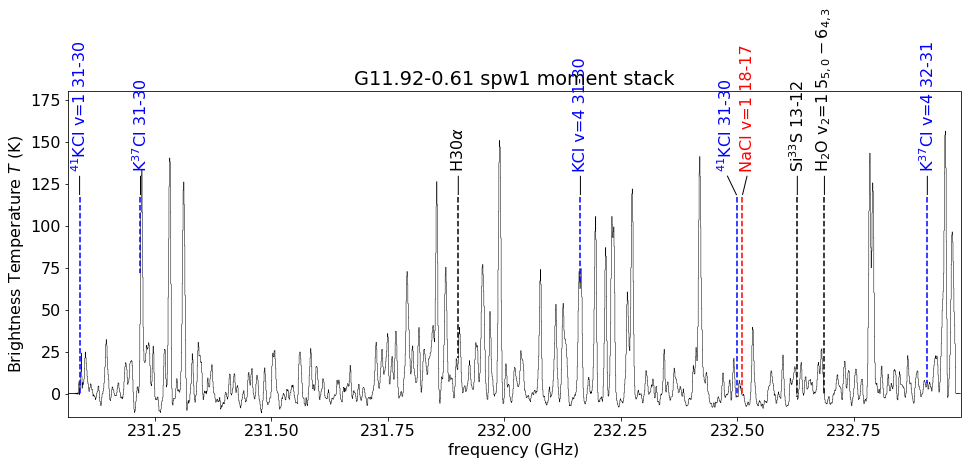

In [43]:
overplot_saltlines(momstackspectra, vcen=0*u.km/u.s, savepath='spectra/figures')

In [44]:
pwd

'/orange/adamginsburg/salt/sanhueza/G11'

In [45]:
ls spectra/figures/

color_labels_G11.92-0.61_spw0_moment1stack.png
color_labels_G11.92-0.61_spw0_moment_stack.png
color_labels_G11.92-0.61_spw0_stack.png
color_labels_G11.92-0.61_spw1_moment1stack.png
color_labels_G11.92-0.61_spw1_moment_stack.png
color_labels_G11.92-0.61_spw1_stack.png
color_labels_G11.92-0.61_spw2_moment1stack.png
color_labels_G11.92-0.61_spw2_moment_stack.png
color_labels_G11.92-0.61_spw2_stack.png
color_labels_G11.92-0.61_spw3_moment1stack.png
color_labels_G11.92-0.61_spw3_moment_stack.png
color_labels_G11.92-0.61_spw3_stack.png
color_labels_G11.92_average_spw1.png
color_labels_G11.92_average_spw2.png
color_labels_G11.92_average_spw3.png
color_labels_G11.92_average_spw4.png
color_labels_spw1.png
color_labels_spw2.png
color_labels_spw3.png
color_labels_spw4.png
G11_61_stack.png
G11.92-0.61.config8.spw0.robust0.5.image_cb_smaller_moment1stack.pdf
G11.92-0.61.config8.spw0.robust0.5.image_cb_smaller_moment1stack.png
G11.92-0.61.config8.spw0.robust0.5.image_cb_smaller_stack.pdf
G11.92-0.61

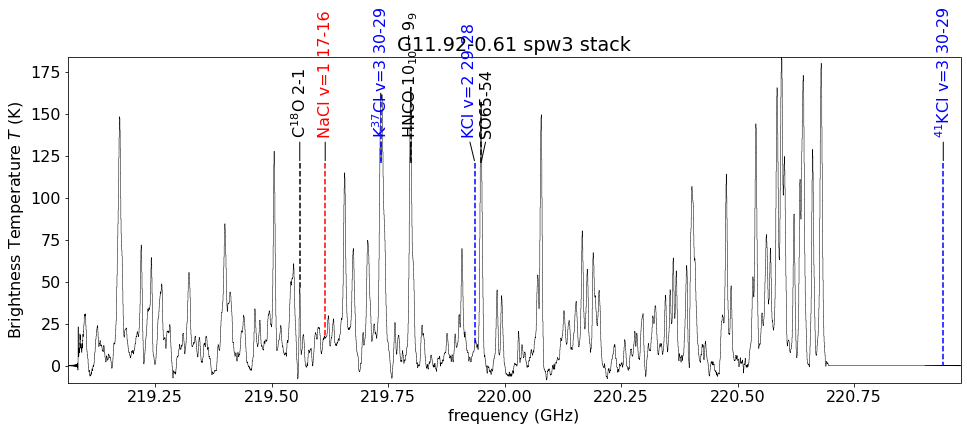

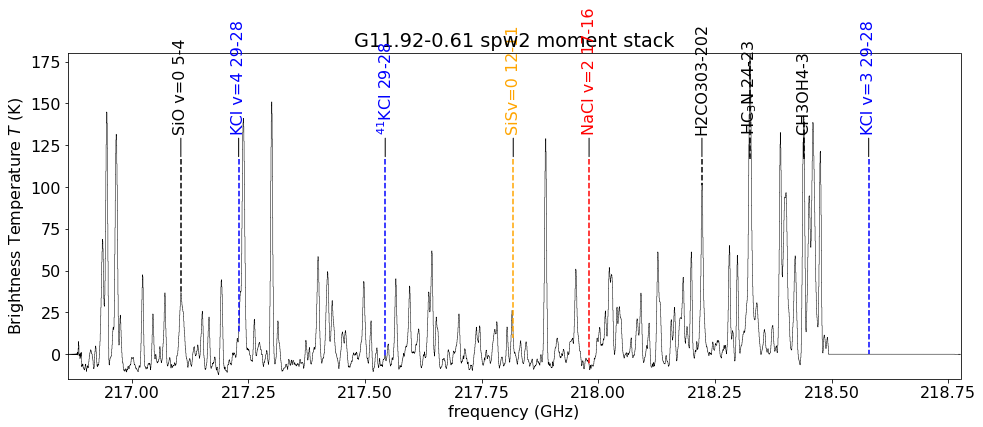

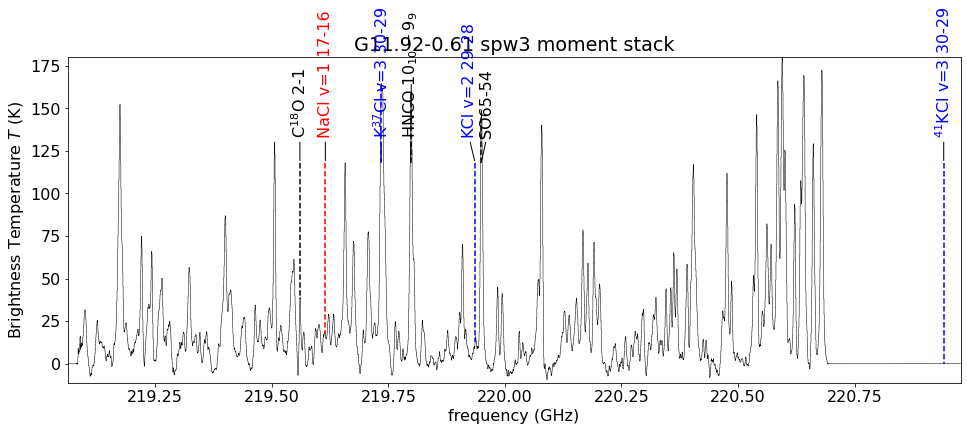

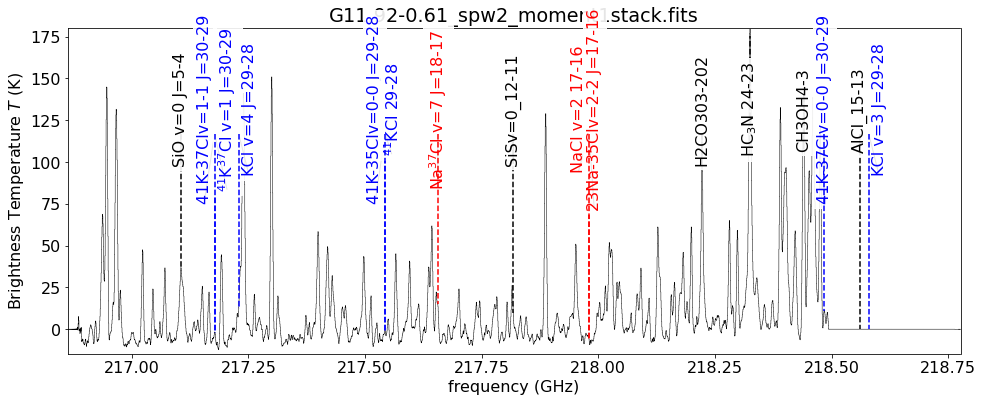

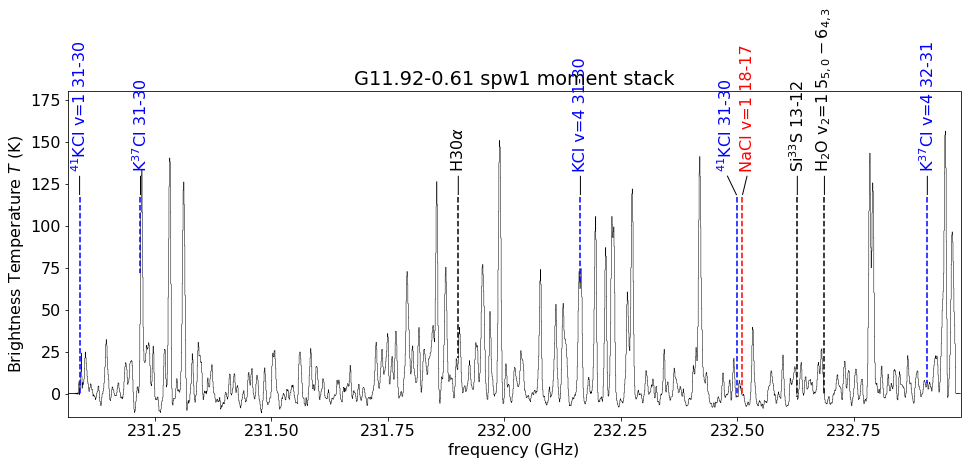

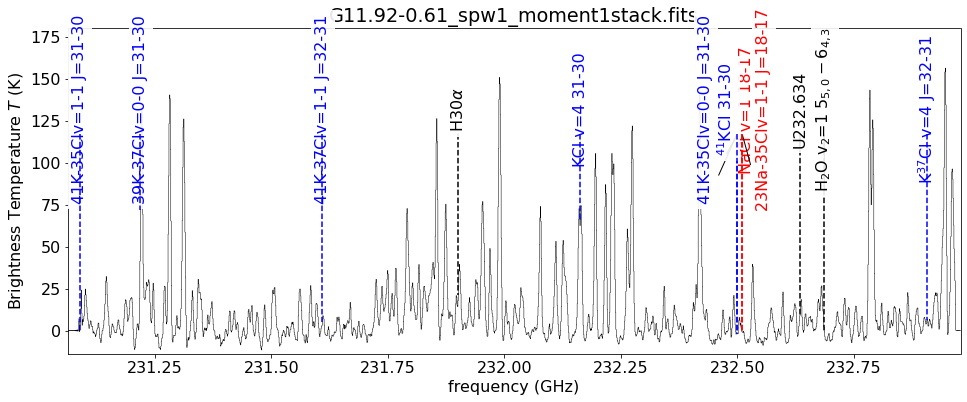

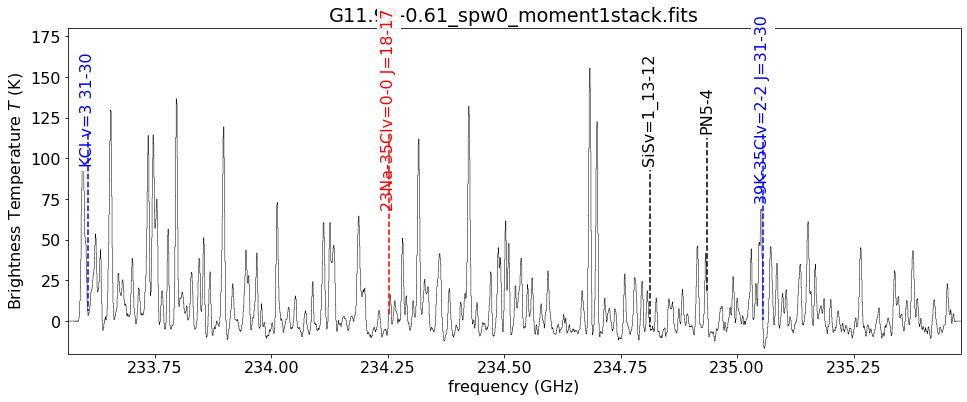

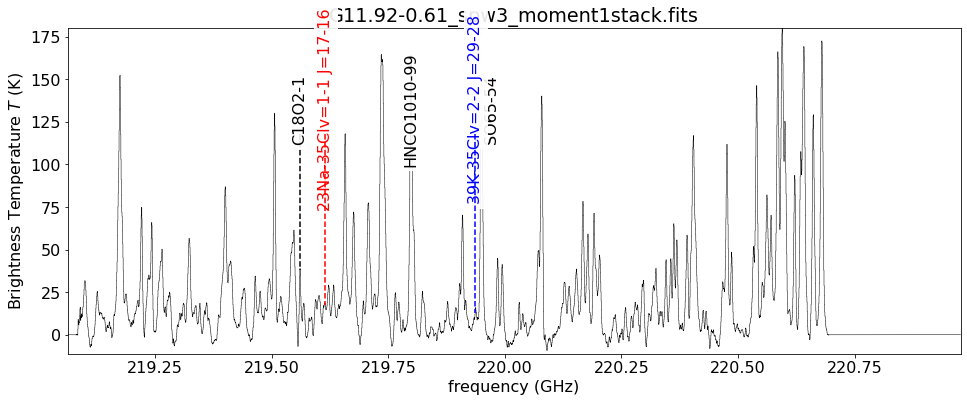

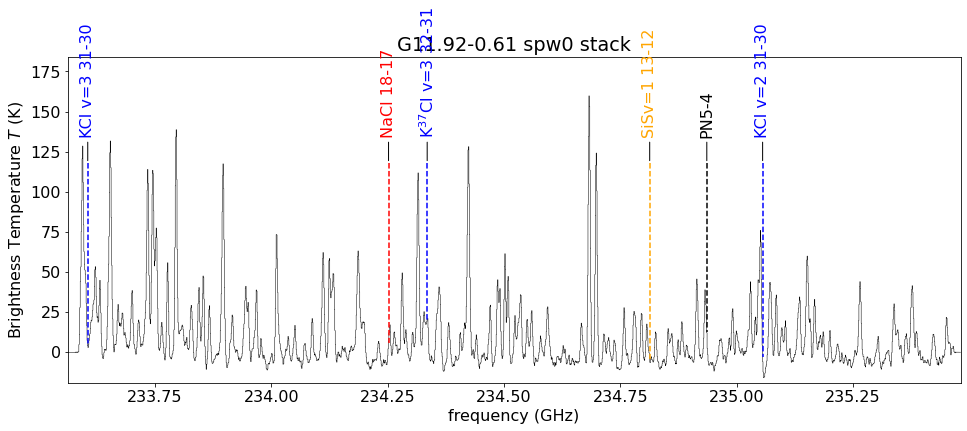

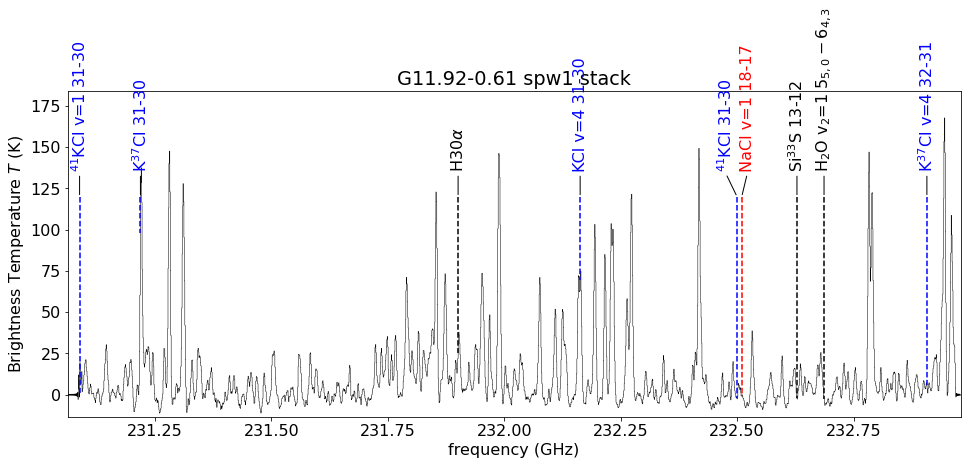

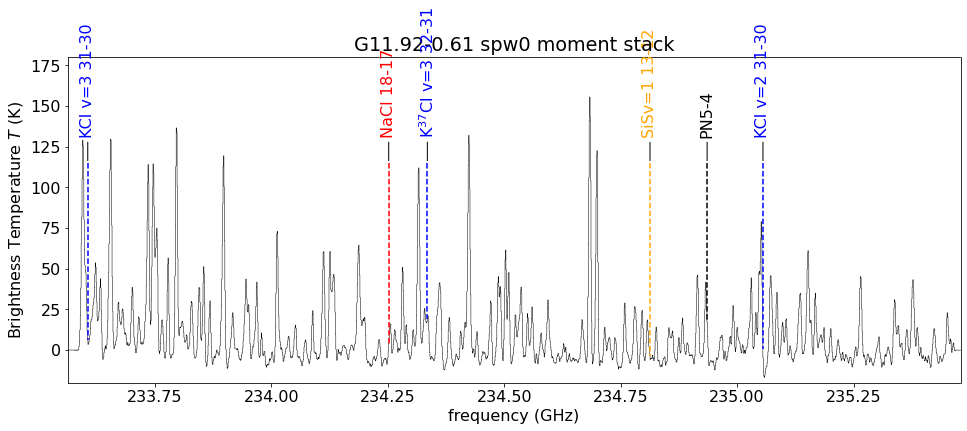

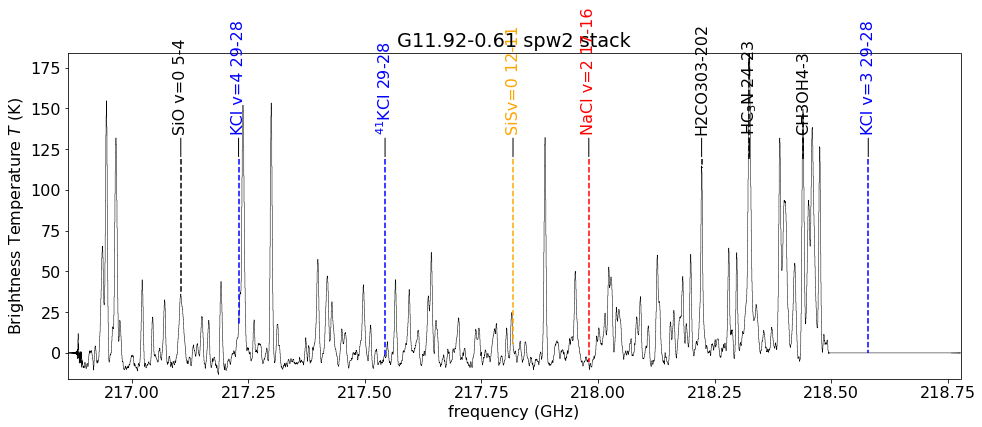

In [46]:
for fn in glob.glob('spectra/figures/color*stack.png'):
    display(Image(fn))

In [47]:
from astropy.stats import mad_std
for sp in stackspectra:
    print(stats.mad_std(sp.data))

7.744845679848465
9.549104216495676
10.907484462227043
14.734069236929157
